# Medical Prognosis with AI - Cox Proportional Hazards and Random Survival Forests

In this project we develop risk models using survival data and a combination of linear and non-linear techniques. The dataset contains survival data of patients with Primary Biliary Cirrhosis (pbc). PBC is an autoimmune disease of the liver caused by a buildup of bile within the liver (cholestasis) that results in damage to the small bile ducts that drain bile from the liver. The goal is to understand the effects of different factors on the survival times of the patients. Along the way it covers the following topics:

- Cox Proportional Hazards
    - Interpreting a Cox Model
    - Evaluation of survival model
- Random Survival Forests
    - Individual Survival Function

## Outline

- [1. Import Packages](#1)
- [2. Load the Dataset](#2)
- [3. Explore the Dataset](#3)
- [4. Cox Proportional Hazards](#4)
- [5. Fitting and Interpreting a Cox Model](#5)
- [6. Hazard ratio](#6)
- [7. Harrell's C-Index](#7)
- [8. Random Survival Forests](#8)
- [9. Individual Survival Function](#9)

<a name='1'></a>
## 1. Import Packages

We'll first import all the packages that we need for this assignment. 

- `sklearn` is one of the most popular machine learning libraries.
- `numpy` is the fundamental package for scientific computing in python.
- `pandas` is what we'll use to manipulate our data.
- `matplotlib` is a plotting library.
- `lifelines` is an open-source survival analysis library.

In [32]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index as cindex
from sklearn.model_selection import train_test_split

from util import load_data

<a name='2'></a>
## 2. Load the Dataset

In [33]:
df = pd.read_csv('pbc.csv')    
df.head()

,id,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,1,400,2,1.0,58.765229,f,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,0,1.0,56.446270,f,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,2,1.0,70.072553,m,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,2,1.0,54.740589,f,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,1,2.0,38.105407,f,0.0,1.0,1.0,0.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


We can make a few transformation to the dataset:
- drop `id` column, (redundant with dataframe index);
- remove `status` with liver transplant and only keep dead or alive patients (0=alive, 1 dead) (in the original dataset we have 0=alive, 1=liver transplant, 2=dead);
- convert `time` to years
- convert `trt` column (treatment) to 0 and 1.
- convert categorical to integer for the variable `sex`.
- drop nan along rows

In [34]:
df = df.drop('id', axis=1)
df = df[df.status != 1] # status   = 0=alive, 1=liver transplant, 2=dead
df.loc[:, 'status'] = df.status / 2.0
df.loc[:, 'time'] = df.time / 365.0
df.loc[:, 'trt'] = df.trt - 1
df.loc[:, 'sex'] = df.sex.map({'f':0.0, 'm':1.0})
df = df.dropna(axis=0)

<a name='3'></a>
## 3. Dataset Exploration

Let's familiarize with the dataframe and the shapes.

In [35]:
print(f"dataframe is of shape {df.shape}")
df.head(10)

dataframe is of shape (258, 19)


,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,1.095890,1.0,0.0,58.765229,0.0,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,12.328767,0.0,0.0,56.446270,0.0,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,2.772603,1.0,0.0,70.072553,1.0,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,5.273973,1.0,0.0,54.740589,0.0,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
6,5.019178,0.0,1.0,55.534565,0.0,0.0,1.0,0.0,0.0,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0
7,6.756164,1.0,1.0,53.056810,0.0,0.0,0.0,0.0,0.0,0.3,280.0,4.00,52.0,4651.2,28.38,189.0,373.0,11.0,3.0
8,6.575342,1.0,0.0,42.507871,0.0,0.0,0.0,1.0,0.0,3.2,562.0,3.08,79.0,2276.0,144.15,88.0,251.0,11.0,2.0
9,0.139726,1.0,1.0,70.559890,0.0,1.0,0.0,1.0,1.0,12.6,200.0,2.74,140.0,918.0,147.25,143.0,302.0,11.5,4.0
10,10.306849,1.0,1.0,53.713895,0.0,0.0,1.0,1.0,0.0,1.4,259.0,4.16,46.0,1104.0,79.05,79.0,258.0,12.0,4.0
11,0.832877,1.0,1.0,59.137577,0.0,0.0,0.0,1.0,0.0,3.6,236.0,3.52,94.0,591.0,82.15,95.0,71.0,13.6,4.0


#### Feature details
It is worth spending a few minutes looking at what the numbers actually means behind the feature columns.
- age of patient
- sex of patient
- presence of ascites: 0=no 1=yes
- presence of hepatomegaly 0=no 1=yes
- presence of spiders 0=no 1=yes
- presence of edema 0=no edema and no diuretic therapy for edema; .5 = edema present without diuretics, or edema resolved by diuretics; 1 = edema despite diuretic therapy
- bili = serum bilirubin in mg/dl
- chol = serum cholesterol in mg/dl
- albumin in gm/dl
- urine copper in ug/day
- alkaline phosphatase in U/liter
- SGOT in U/ml
- triglicerides in mg/dl
- platelets per cubic ml / 1000
- prothrombin time in seconds
- histologic stage of disease

But let's look an given individual

In [36]:
i = 20
df.iloc[i, :]

time          11.175342
status         1.000000
trt            0.000000
age           44.520192
sex            1.000000
ascites        0.000000
hepato         1.000000
spiders        0.000000
edema          0.000000
bili           2.100000
chol         456.000000
albumin        4.000000
copper       124.000000
alk.phos    5719.000000
ast          221.880000
trig         230.000000
platelet      70.000000
protime        9.900000
stage          2.000000
Name: 23, dtype: float64

Now, we split the dataset into training, validation and test set using a 60/20/20 split.

In [37]:
np.random.seed(0)
df_dev, df_test = train_test_split(df, test_size = 0.2)
df_train, df_val = train_test_split(df_dev, test_size = 0.25)

print("Total number of patients:", df.shape[0])
print("Total number of patients in training set:", df_train.shape[0])
print("Total number of patients in validation set:", df_val.shape[0])
print("Total number of patients in test set:", df_test.shape[0])

Total number of patients: 258
Total number of patients in training set: 154
Total number of patients in validation set: 52
Total number of patients in test set: 52


Before proceeding to modeling, let's normalize the continuous covariates to make sure they're on the same scale. Also, we should normalize the test data using statistics from the train data.

In [38]:
continuous_columns = ['age', 'bili', 'chol', 'albumin', 'copper', 'alk.phos', 'ast', 'trig', 'platelet', 'protime']

# compute statistics over the train set
mean = df_train.loc[:, continuous_columns].mean()
std = df_train.loc[:, continuous_columns].std()

# normalize all sets using the train set stats
df_train.loc[:, continuous_columns] = (df_train.loc[:, continuous_columns] - mean) / std
df_val.loc[:, continuous_columns] = (df_val.loc[:, continuous_columns] - mean) / std
df_test.loc[:, continuous_columns] = (df_test.loc[:, continuous_columns] - mean) / std

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-38-54221e950625>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, continuous_columns] = (df_train.loc[:, continuous_columns] - mean) / std
<ipython-input-38-54221e950625>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, continuous_co

Let's check the summary statistics on our training dataset to make sure it's standardized. For that, we verify that the mean is close to zero and that the standard deviation is 1.

In [39]:
df_train.loc[:, continuous_columns].describe()

,age,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime
count,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02
mean,9.963170e-16,-3.287414e-16,1.355337e-16,1.420220e-16,-4.708535e-18,1.124642e-16,-1.268826e-15,7.083079e-17,2.883696e-17,1.289877e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.304107e+00,-5.735172e-01,-1.115330e+00,-3.738104e+00,-9.856552e-01,-7.882167e-01,-1.489281e+00,-1.226674e+00,-2.058899e+00,-1.735556e+00
25%,-6.535035e-01,-4.895812e-01,-5.186963e-01,-5.697976e-01,-6.470611e-01,-5.186471e-01,-8.353982e-01,-6.884514e-01,-6.399831e-01,-7.382590e-01
50%,-6.443852e-03,-3.846612e-01,-2.576693e-01,5.663556e-02,-3.140636e-01,-3.416086e-01,-2.260984e-01,-2.495932e-01,-4.100373e-02,-1.398807e-01
75%,5.724289e-01,2.977275e-02,1.798617e-01,6.890921e-01,3.435366e-01,-4.620597e-03,6.061159e-01,3.755727e-01,6.617988e-01,3.587680e-01
max,2.654276e+00,5.239050e+00,6.243146e+00,2.140730e+00,5.495204e+00,4.869263e+00,3.058176e+00,5.165751e+00,3.190823e+00,4.447687e+00


<a name='4'></a>
## 4. Cox Proportional Hazards

The goal is to build a risk score using the survival data that we have. We'll begin by fitting a Cox Proportional Hazards model to the data.

The Cox Proportional Hazards model describes the hazard for an individual $i$ at time $t$ as 

$$
\lambda(t, x) = \lambda_0(t)e^{\theta^T X_i}
$$

The $\lambda_0$ term is a baseline hazard and incorporates the risk over time, and the other term incorporates the risk due to the individual's covariates. After fitting the model, we can rank individuals using the person-dependent risk term $e^{\theta^T X_i}$. 

Categorical variables cannot be used in a regression model as they are. In order to use them, conversion to a series of variables is required.

Since the data has a mix of categorical (`stage`) and continuous (`wblc`) variables, before we proceed further we need to do some data engineering. To tackle the issue at hand we use the `Dummy Coding` technique. In order to use Cox Proportional Hazards, we have to turn the categorical data into one hot features. Luckily, Pandas has a built-in function called `get_dummies` that make it easy to implement this function. It turns categorical features into multiple binary features.

<img src="1-hot-encode.png" style="padding-top: 5px;width: 60%;left: 0px;margin-left: 150px;margin-right: 0px;">




In [40]:
def to_one_hot(dataframe, columns):
    '''
    Convert columns in dataframe to one-hot encoding.
    Args:
        dataframe (dataframe): pandas dataframe containing covariates
        columns (list of strings): list categorical column names to one hot encode
    Returns:
        one_hot_df (dataframe): dataframe with categorical columns encoded
                            as binary variables
    '''
    
    one_hot_df = pd.get_dummies(dataframe, columns=columns, 
                                drop_first=True, dtype=np.float64)
    
    return one_hot_df

Now we transform the training, validation, and test sets with the function we've just created.

In [41]:
# List of categorical columns
to_encode = ['edema', 'stage']

one_hot_train = to_one_hot(df_train, to_encode)
one_hot_val = to_one_hot(df_val, to_encode)
one_hot_test = to_one_hot(df_test, to_encode)

print(one_hot_val.columns.tolist())
print(f"There are {len(one_hot_val.columns)} columns")

['time', 'status', 'trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'bili', 'chol', 'albumin', 'copper', 'alk.phos', 'ast', 'trig', 'platelet', 'protime', 'edema_0.5', 'edema_1.0', 'stage_2.0', 'stage_3.0', 'stage_4.0']
There are 22 columns


#### Look for new features
Let's look at one of the transformed data sets. Notice the new features edema_0.5, edema_1.0, etc.

In [42]:
print(one_hot_train.shape)
one_hot_train.head()

(154, 22)


,time,status,trt,age,sex,ascites,hepato,spiders,bili,chol,...,alk.phos,ast,trig,platelet,protime,edema_0.5,edema_1.0,stage_2.0,stage_3.0,stage_4.0
279,3.868493,0.0,0.0,-0.414654,0.0,0.0,0.0,0.0,-0.300725,-0.096081,...,0.167937,0.401418,0.330031,0.219885,-1.137178,0.0,0.0,0.0,1.0,0.0
137,3.553425,1.0,0.0,0.069681,1.0,0.0,1.0,0.0,0.895363,0.406085,...,0.101665,0.472367,1.621764,-0.120868,-0.239610,0.0,0.0,0.0,1.0,0.0
249,4.846575,0.0,1.0,-0.924494,0.0,0.0,1.0,0.0,-0.510565,-0.225352,...,0.245463,1.899020,-0.580807,0.422207,0.159309,0.0,0.0,0.0,0.0,1.0
266,0.490411,1.0,0.0,1.938314,0.0,1.0,1.0,1.0,0.748475,-0.608191,...,-0.650254,-0.288898,-0.481443,-0.727833,1.356065,0.0,1.0,0.0,0.0,1.0
1,12.328767,0.0,0.0,0.563645,0.0,0.0,1.0,1.0,-0.405645,-0.210436,...,2.173526,-0.144699,-0.531125,-0.450972,-0.139881,0.0,0.0,0.0,1.0,0.0


<a name='5'></a>
## 5. Fitting and Interpreting a Cox Model

We fit the Cox Proportional Hazards model using the `lifelines` package.

In [43]:
cph_model = CoxPHFitter()
cph_model.fit(one_hot_train, duration_col = 'time', event_col = 'status', step_size=0.1)

<lifelines.CoxPHFitter: fitted with 154 total observations, 90 right-censored observations>

We can use `cph_model.print_summary()` to view the coefficients associated with each covariate as well as confidence intervals. 

In [44]:
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 154 total observations, 90 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 154
number of events observed = 64
   partial log-likelihood = -230.82
         time fit was run = 2020-08-31 15:39:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
trt        -0.22       0.80       0.30            -0.82             0.37                 0.44                 1.45
age         0.23       1.26       0.19            -0.13             0.60                 0.88                 1.82
sex         0.34       1.41       0.40            -0.45             1.14                 0.64                 3.11
ascites    -0.10       0.91       0.56            -1.20             1.01                 0.30                 2.75
hepato      0.31       1.36       0.38            -0.44             1.06                 0.64                 2.89
spiders    -0.18       0.83       0.38            -0.94             0.57                 0.39                 1.77
bili        0.05       1.05       0.18            -0.29             0.39                 0.75                 1.48
chol        0.19       1.20       0.15            -0.10             0.47                 0.91                 1.60
albumin    -0.40       0.67       0.18            -0.75            -0.06                 0.47                 0.94
copper      0.30       1.35       0.16            -0.01             0.61                 0.99                 1.84
alk.phos   -0.22       0.80       0.14            -0.49             0.05                 0.61                 1.05
ast         0.21       1.24       0.16            -0.10             0.53                 0.91                 1.69
trig        0.20       1.23       0.16            -0.11             0.52                 0.89                 1.68
platelet    0.14       1.15       0.15            -0.16             0.43                 0.86                 1.54
protime     0.36       1.43       0.17             0.03             0.69                 1.03                 1.99
edema_0.5   1.24       3.47       0.46             0.35             2.14                 1.42                 8.50
edema_1.0   2.02       7.51       0.60             0.84             3.20                 2.31                24.43
stage_2.0   1.21       3.35       1.08            -0.92             3.33                 0.40                28.06
stage_3.0   1.18       3.27       1.09            -0.96             3.33                 0.38                27.86
stage_4.0   1.41       4.10       1.15            -0.85             3.67                 0.43                39.43
              z      p   -log2(p)
covariate                        
trt       -0.73   0.46       1.11
age        1.26   0.21       2.27
sex        0.84   0.40       1.33
ascites   -0.17   0.86       0.21
hepato     0.81   0.42       1.26
spiders   -0.47   0.64       0.66
bili       0.29   0.77       0.37
chol       1.28   0.20       2.33
albumin   -2.28   0.02       5.46
copper     1.91   0.06       4.14
alk.phos  -1.62   0.11       3.24
ast        1.34   0.18       2.48
trig       1.27   0.21       2.28
platelet   0.92   0.36       1.48
protime    2.15   0.03       4.97
edema_0.5  2.72   0.01       7.28
edema_1.0  3.35 <0.005      10.28
stage_2.0  1.11   0.27       1.91
stage_3.0  1.08   0.28       1.84
stage_4.0  1.22   0.22       2.18
---
Concordance = 0.83
Partial AIC = 501.64
log-likelihood ratio test = 97.63 on 20 df
-log2(p) of ll-ratio test = 38.13

#### Was treatment beneficial?
- We see that the treatment (`trt`) was beneficial because it has a negative impact on the hazard (the coefficient is negative, and exp(coef) is less than 1)

- the hazard ratio (which is how much an incremental increase in the feature variable changes the hazard) is ~0.8, because this is the exp(coef) of treatment.

We can compare the predicted survival curves for treatment variables using the `plot_covariate_groups()` function. 
- The y-axis is th survival rate
- The x-axis is time

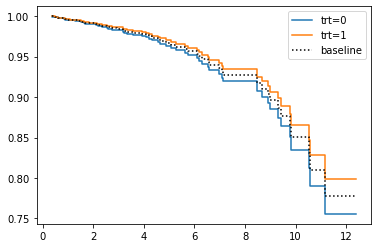

In [45]:
cph_model.plot_partial_effects_on_outcome('trt', values=[0, 1])

The group without treatment has a lower survival rate at all times (the x-axis is time) compared to the treatment group.

<a name='6'></a>
## 6. Hazard Ratio

The Hazard Ratio between two patients is the likelihood of one patient (e.g smoker) being more at risk than the other (e.g non-smoker).
$$
\frac{\lambda_{smoker}(t)}{\lambda_{nonsmoker}(t)} = e^{\theta (X_{smoker} - X_{nonsmoker})^T}
$$

Where

$$
\lambda_{smoker}(t) = \lambda_0(t)e^{\theta X_{smoker}^T}
$$
and
$$
\lambda_{nonsmoker}(t) = \lambda_0(t)e^{\theta X_{nonsmoker}^T} \\
$$

Below we write a function to compute the hazard ratio between two individuals given the cox model's coefficients.

In [46]:
def hazard_ratio(case_1, case_2, cox_params):
    '''
    Return the hazard ratio of case_1 : case_2 using
    the coefficients of the cox model.
    
    Args:
        case_1 (np.array): (1 x d) array of covariates
        case_2 (np.array): (1 x d) array of covariates
        model (np.array): (1 x d) array of cox model coefficients
    Returns:
        hazard_ratio (float): hazard ratio of case_1 : case_2
    '''
    
    hr = np.exp(cox_params@(case_1-case_2))
    
    return hr

Now, we can evaluate it on pair of indivduals, for example `i = 1` and `j = 5`

In [47]:
i = 1
case_1 = one_hot_train.iloc[i, :].drop(['time', 'status'])

j = 5
case_2 = one_hot_train.iloc[j, :].drop(['time', 'status'])

print(hazard_ratio(case_1.values, case_2.values, cph_model.params_.values))

15.029017732492221


The hazard ratio of case 1 / case 2 is greater than 1, so case 1 had a higher hazard relative to case 2

<a name='7'></a>
## 7. Harrell's C-index

To evaluate how good the model is performing, we write our own version of the C-index. C-index in the survival context is the probability that, given a randomly selected pair of individuals, the one who died sooner has a higher risk score. The pair is called concordant.

However, we need to take into account censoring. Imagine a pair of patients, $A$ and $B$. 

#### Scenario 1
- A was censored at time $t_A$, i.e. A was alive when he was extracted from the study, but no data are available w.r.t A after that time point. A could have died a week after, or several years later.
- B died at $t_B$
- $t_A < t_B$. 

Because of censoring, we can't say whether $A$ or $B$ should have a higher risk score. Indeed, A may have died between $t_A$ and $t_B$ 

#### Scenario 2
Now imagine that $t_A > t_B$.

- A was censored at time $t_A$ 
- B died at $t_B$
- $t_A > t_B$

Now we can definitively say that $B$ should have a higher risk score than $A$, since we know for a fact that $A$ lived longer. 

Therefore, when computing the C-index
- We should only consider pairs where at most one person is censored
- If they are censored, then their censored time should occur *after* the other person's time of death. 

The metric we get if we use this rule is called **Harrel's C-index**.

Note that in this case, being censored at time $t$ means that the true death time was some time AFTER time $t$ and not at $t$. 
- Therefore if $t_A = t_B$ and A was censored:
    - Then $A$ actually lived longer than $B$. 
    - This will affect we deal with ties!

### Computation of Harrell's C-index

In [48]:
def harrell_c(y_true, scores, event):
    '''
    Compute Harrel C-index given true event/censoring times,
    model output, and event indicators.
    
    Args:
        y_true (array): array of true event times
        scores (array): model risk scores
        event (array): indicator, 1 if event occurred at that index, 0 for censorship
    Returns:
        result (float): C-index metric
    '''
    
    n = len(y_true)
    assert (len(scores) == n and len(event) == n)
    
    # initalise counters
    concordant = 0.0
    permissible = 0.0
    ties = 0.0
    
    result = 0.0
    
    # use double for loop to go through cases
    for i in range(n):
        # set lower bound on j to avoid double counting
        for j in range(i+1, n):
            
            # check if at most one is censored
            if not ((event[i]==0) and (event[j]==0)):
            
                # check if neither are censored
                if (event[i]==1) & (event[j]==1): # not censored if both died
                    permissible += 1 # then it is a permissible pair
                    
                    # check if scores are tied
                    if scores[i]==scores[j]:
                        ties += 1
                    
                    # check for concordant
                    elif (scores[i]<scores[j]) & (y_true[i]>y_true[j]):
                        concordant += 1 # if individual j died early and had the highest risk
                        # score, it is a concordant pair
                    elif (scores[i]>scores[j]) & (y_true[i]<y_true[j]):
                        concordant += 1 # same for i
                
                # check if one is censored
                elif event[i]==0 or event[j]==0:
                    
                    # get censored index
                    
                    # initialise
                    censored = j
                    uncensored = i
                    
                    # reverse if i is actually censored
                    if event[i] == 0:
                        censored = i
                        uncensored = j
                        
                    # check if permissible
                    # Note: in this case, we are assuming that censored at a time
                    # means that patient did NOT die at that time. That is, if he
                    # lives until time 30 and have event = 0, then he lived THROUGH
                    # time 30.
                    
                    if y_true[uncensored] <= y_true[censored]:
                        
                        permissible += 1
                        
                        # check if scores are tied
                        if scores[censored]==scores[uncensored]:
                            # update ties 
                            ties += 1
                            
                        # check if scores are concordant 
                        if scores[uncensored]>scores[censored]:
                            concordant += 1    
    
    # set result to c-index computed from number of concordant pairs,
    # number of ties, and number of permissible pairs  
    result = (concordant + 0.5 * ties) / permissible
    
    return result

Let's use the Harrell's C-index function to evaluate the cox model on our data sets.

In [49]:
# Train
scores = cph_model.predict_partial_hazard(one_hot_train)
cox_train_scores = harrell_c(one_hot_train['time'].values,
                             scores.values, one_hot_train['status'].values)
# Validation
scores = cph_model.predict_partial_hazard(one_hot_val)
cox_val_scores = harrell_c(one_hot_val['time'].values, 
                           scores.values, one_hot_val['status'].values)
# Test
scores = cph_model.predict_partial_hazard(one_hot_test)
cox_test_scores = harrell_c(one_hot_test['time'].values, 
                            scores.values, one_hot_test['status'].values)

print("Train:", cox_train_scores)
print("Val:", cox_val_scores)
print("Test:", cox_test_scores)

Train: 0.8265139116202946
Val: 0.8544776119402985
Test: 0.8478543563068921


The values obtained are pretty good. There are no big gap, or performance loss between the train set and the val or test set which suggests that we are not overfitting the dataset. The performance has even slightly increased. This is likely to be due to the relatively low number of patients within these sets, which bring some additional statistical variability.

<a name='8'></a>
## 8. Random Survival Forests

This performed well, but we may better perform by using a machine learning approach. So let's try to implement a Random Survival Forest. To do this, we use the `RandomSurvivalForest` function from `scikit-survival`. This package is developped by Sebastian Pölsterl and include the required function. We will need however to fit the data format to what is required in input of the Random Survival Forest function.

In [50]:
from sksurv.datasets import get_x_y
from sksurv.ensemble import RandomSurvivalForest

In [51]:
# to install the libary needed, uncomment and run the following
#conda install -c sebp scikit-survival

In [52]:
one_hot_train.head()

,time,status,trt,age,sex,ascites,hepato,spiders,bili,chol,...,alk.phos,ast,trig,platelet,protime,edema_0.5,edema_1.0,stage_2.0,stage_3.0,stage_4.0
279,3.868493,0.0,0.0,-0.414654,0.0,0.0,0.0,0.0,-0.300725,-0.096081,...,0.167937,0.401418,0.330031,0.219885,-1.137178,0.0,0.0,0.0,1.0,0.0
137,3.553425,1.0,0.0,0.069681,1.0,0.0,1.0,0.0,0.895363,0.406085,...,0.101665,0.472367,1.621764,-0.120868,-0.239610,0.0,0.0,0.0,1.0,0.0
249,4.846575,0.0,1.0,-0.924494,0.0,0.0,1.0,0.0,-0.510565,-0.225352,...,0.245463,1.899020,-0.580807,0.422207,0.159309,0.0,0.0,0.0,0.0,1.0
266,0.490411,1.0,0.0,1.938314,0.0,1.0,1.0,1.0,0.748475,-0.608191,...,-0.650254,-0.288898,-0.481443,-0.727833,1.356065,0.0,1.0,0.0,0.0,1.0
1,12.328767,0.0,0.0,0.563645,0.0,0.0,1.0,1.0,-0.405645,-0.210436,...,2.173526,-0.144699,-0.531125,-0.450972,-0.139881,0.0,0.0,0.0,1.0,0.0


To use `get_x_y` we need **attr_labels** (sequence of str or None) – A list of one or more columns that are considered the label. If survival is True, then attr_labels has two elements: 1) the name of the column denoting the event indicator, and 2) the name of the column denoting the survival time. If the sequence contains None, then labels are not retrieved and only a data frame with features is returned.

In [53]:
# attr_label = one_hot_train.columns.drop(["time","status"]).to_list()
attr_label = ["status","time"]
print(attr_label)

['status', 'time']


In [54]:
pos_label = 1.0 # Which value of the event indicator column denotes that a
# patient experienced an event. This value is ignored if survival is False.
survival = True # Whether to return y that can be used for survival analysis

In [55]:
# from dataframe object, convert it to the right format needed by the RFS model
X_train, y_train = get_x_y(one_hot_train, attr_label, pos_label)
X_val, y_val = get_x_y(one_hot_val, attr_label, pos_label)
X_test, y_test = get_x_y(one_hot_test, attr_label, pos_label)

In [56]:
rsf = RandomSurvivalForest(n_estimators=500,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=0)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=500, n_jobs=-1,
                     random_state=0)

In [70]:
print(f"Random Survival Forest score on train set: {rsf.score(X_train, y_train):f}")
print(f"Random Survival Forest score on validation set: {rsf.score(X_val, y_val):f}")
print(f"Random Survival Forest score on test set: {rsf.score(X_test, y_test):f}")

Random Survival Forest score on train set: 0.851227
Random Survival Forest score on validation set: 0.874378
Random Survival Forest score on validation set: 0.860858


The concordance index on the validation set and train set has improve by absolute 2% with respect to the cox proportional hazards model. That's great!

Let's now corroborate this metric with Harrel's c-index function that we previously manually implemented for the cox proportional hazard model.

In [58]:
y_train_pred = rsf.predict(X_train)

In [59]:
print("Survival Forest Train Score:", harrell_c(one_hot_train['time'].values, 
                                                y_train_pred, 
                                                one_hot_train['status'].values))

Survival Forest Train Score: 0.851227495908347


We have confirmation that the custom Harrel's C-index is doing what we expect. This concludes that random survival forest slightly outperforms the Cox model. In the following we investigate a bit further why they differ.

<a name='9'></a>
## 9. Individual Survival Function

In this section we are intered with individual patient survival function. We are using the `.predict_survival_function()` method of the `RandomSurvivalForest` model that has been trained. For readability purpose, we only select the first 10 rows of patients of the test set.

In [60]:
survival = rsf.predict_survival_function(X_test.iloc[:10,:])

/opt/anaconda3/lib/python3.8/site-packages/sksurv/ensemble/forest.py:526: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(


In [61]:
survival.shape

(10, 64)

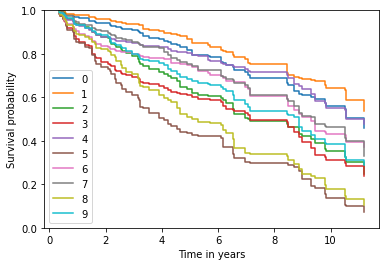

In [64]:
for i, s in enumerate(survival):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in years")
plt.ylim([0,1])
plt.legend()

Fromn this graph we can see the diversity of survival function among individuals, with some having only about 50% of survival up to 4 years in the future. Even though this plot is informative to visual at large what are how the survival function spreads over individuals, and its shape, it is hard to retrieve numerical values. Therefore we implement a function called `get_survival_proba`that given a patient's input and a time point, returns the probability for being still alive passed that time.

In [ ]:
def get_survival_proba(model, data, patient_row, timepoint):
    """ Compute the probability to survive passed a given timepoint 
    
    Args:
        model - RandomSurvivalForest mdeol that has been fitted to the data
        data (dataframe) of shape (n_examples x n_features)
        patient_row (int) - dataframe row containing the patient for the evaluation
        timepoint (float) - time at which to compute the probability of survival.
    Return
        p (float) - probability of survival of the patient up to that timepoint.
    """
    data = data.iloc[patient_row:patient_row+1,:]
    pred = model.predict_survival_function(data, return_array=True)
    p = np.interp(timepoint, rsf.event_times_, pred[0])
    return p

#
print("Survival of patient 0 at time = 0y:",get_survival_proba(rsf, X_test, 0, 0))
print("Survival of patient 0 at time = 2y:",get_survival_proba(rsf, X_test, 0, 2))
print("Survival of patient 0 at time = 10y:",get_survival_proba(rsf, X_test, 0, 10))
print("\n")

print("Survival of patient 1 at time = 4y:",get_survival_proba(rsf, X_test, 1, 4))
print("Survival of patient 2 at time = 4y:",get_survival_proba(rsf, X_test, 2, 4))
print("Survival of patient 3 at time = 4y:",get_survival_proba(rsf, X_test, 3, 4))

## Conclusion
In this notebook we have built 2 models to predict risk score and survival probabilities of patients. The so-called Cox Proportional Hazards model was used and achieved Harrel's c-index of ≈ 0.85 on the validation and test set with no signs of over- of underfitting. Then we implemented a machine learning-based approach using a Random Survival Forest algorithm. The latter one achieve a Harrel's c-score of ≈ 0.87 on the validation and test set. This outperforms the cox-proportional hazard model by 0.02. However, one must recall that the validation and test set only comprised a 52 individuals. In the end, it is fair to conclude that both models provided good and comparable performances